# A/B test quantiles

In an A/B test we often only look at the difference in means between two groups (a control and treatment group).
In the case of a continuous outcome, this ignores what happens at the extremes.

For example in a treatment group, if the high outcomes become much higher, but the low outcomes become much lower, the mean could be the same, but the outcome distribution would be quite different.

If we create Q-Q plots we can compare the whole distribution. Using bootstrapping we can construct confidence intervals around these.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_19373/4221165740.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Let's generate some random data.

We have a feature that give some outcome in a control case.
We then create a treatment outcome which differs from the control.

In [89]:
import numpy as np

n_samples = int(1e3)
rnd = np.random.default_rng(None)

# uniform [0,1] distributed values
features = rnd.random(size=n_samples)

Comparing different treatment effects

Given features, return a reward.

We create a treatment outcome which is linearly different to the control.
We also create a treatment outcome which has more of an effect on extreme feature values.

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_19373/574932311.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


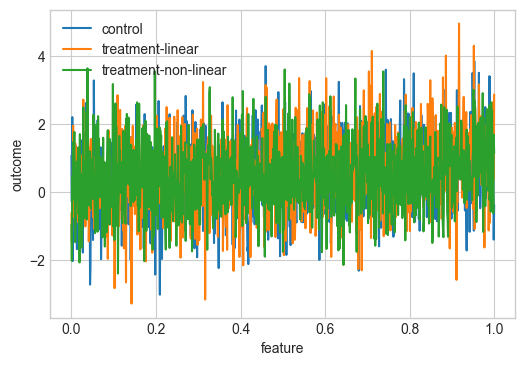

In [176]:
import scipy.special


def outcome_linear(x: np.array, bias: float = 0.00, scale: float = 1.0) -> np.array:
    return x * scale + bias + rnd.normal(scale=1.0, size=x.shape)


def outcome_non_linear(x: np.array, bias: float = 0.05, scale: float = 1.0) -> np.array:
    return scale * (x - 0.5) ** 3 + 0.5 + bias + rnd.normal(scale=1.0, size=x.shape)


x = np.linspace(0, 1, 1000)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, x, linestyle="--", color="k", alpha=0.5)
ax.plot(x, outcome_linear(x), label="control")
ax.plot(x, outcome_linear(x, bias=0.1), label="treatment-linear")
ax.plot(x, outcome_non_linear(x, scale=2), label="treatment-non-linear")
ax.legend()
ax.set(xlabel="feature", ylabel="outcome")
fig.show()


The average difference between the treatments and the control is the same for both treatment outcomes.

In [190]:
def generate_outcomes(n_samples:int = int(1e6)):
    features = rnd.random(size=n_samples)
    outcome_df = pd.DataFrame(
        data=np.vstack(
            [
                outcome_linear(features),
                outcome_linear(features, bias=0.05),
                outcome_non_linear(features, scale=2, bias=0.05),
            ]
        ).transpose(),
        columns=["control", "treatment-linear", "treatment-non-linear"],
    )
    return outcome_df

outcome_df = generate_outcomes(int(5e3))
outcome_df.mean()


control                 0.475812
treatment-linear        0.553062
treatment-non-linear    0.543547
dtype: float64

A/B test via linear regression shows both of the treatment outcomes have the same uplift.

In [191]:
ab_df = pd.DataFrame(
    data=np.vstack(
        [
            np.concatenate(
                [
                    np.full(shape=(outcome_df.shape[0]), fill_value=0),
                    np.full(shape=(outcome_df.shape[0]), fill_value=1),
                ]
            ),
            np.concatenate([outcome_df['control'], outcome_df['treatment-non-linear']]),
        ]
    ).transpose(),
    columns=['t','y']
)


In [192]:
import statsmodels.api as sm

sm_results = sm.OLS(endog=ab_df['y'], exog=sm.add_constant(ab_df['t'])).fit()
sm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     11.04
Date:                Sat, 14 Oct 2023   Prob (F-statistic):           0.000897
Time:                        22:39:29   Log-Likelihood:                -14382.
No. Observations:               10000   AIC:                         2.877e+04
Df Residuals:                    9998   BIC:                         2.878e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4758      0.014     33.001      0.000       0.448       0.504
t              0.0677      0.020      3.322      0.001       0.028       0.108
==============================================================================
Omnibus:                        1.650   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.438   Jarque-Bera (JB):                1.662
Skew:                          -0.017   Prob(JB):                        0.436
Kurtosis:                       2.947   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Q-Q plots

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_19373/2608197162.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


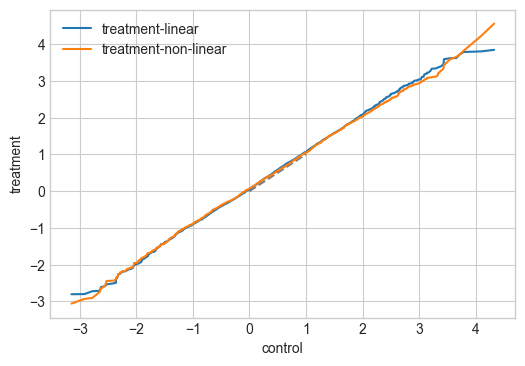

In [193]:
x = np.linspace(0, 1, 1000)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, x, linestyle="--", color="k", alpha=0.5)
ax.plot(
    outcome_df["control"].sort_values(),
    outcome_df["treatment-linear"].sort_values(),
    label="treatment-linear",
)
ax.plot(
    outcome_df["control"].sort_values(),
    outcome_df["treatment-non-linear"].sort_values(),
    label="treatment-non-linear",
)
ax.legend()
ax.set(xlabel="control", ylabel="treatment")
fig.show()


Bootstrap for confidence intervals

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_19373/1686878509.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


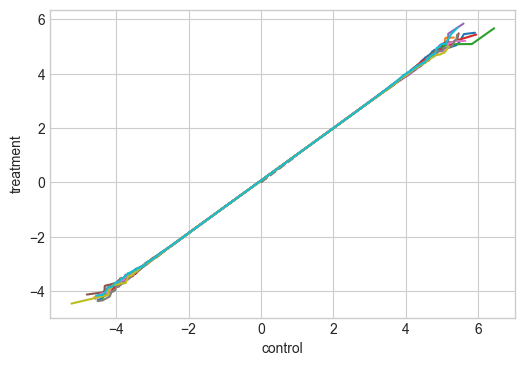

In [194]:
x = np.linspace(0, 1, 1000)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, x, linestyle="--", color="k", alpha=0.5)

for _idx in range(10):
    outcome_df = generate_outcomes()

    # ax.plot(
    #     outcome_df["control"].sort_values(),
    #     outcome_df["treatment-linear"].sort_values(),
    #     # label="treatment-linear",
    # )
    ax.plot(
        outcome_df["control"].sort_values(),
        outcome_df["treatment-non-linear"].sort_values(),
        label="treatment-non-linear",
    )
# ax.legend()
ax.set(xlabel="control", ylabel="treatment")
fig.show()



Use a different sample for control and treatment for realism.

In [173]:
features_c = rnd.random(size=n_samples)
control = outcome_linear(features_c)
features_t = rnd.random(size=n_samples)
treatment = outcome_linear(features_t, bias=0.05)

ab_df = pd.DataFrame(
    data=np.vstack(
        [
            np.concatenate([features_c, features_t]),
            np.concatenate(
                [
                    np.full(shape=(control.shape[0]), fill_value=0),
                    np.full(shape=(treatment.shape[0]), fill_value=1),
                ]
            ),
            np.concatenate([control, treatment]),
        ]
    ).transpose(),
    columns=['x','t','y']
)
ab_df


,x,t,y
0,0.477424,0.0,0.498532
1,0.100214,0.0,0.114248
2,0.517942,0.0,0.626761
3,0.681055,0.0,0.738179
4,0.647443,0.0,0.694485
...,...,...,...
1999995,0.812867,1.0,0.812958
1999996,0.985032,1.0,0.803237
1999997,0.555172,1.0,0.569289
1999998,0.902769,1.0,0.985973


In [166]:
ab_df.groupby(['t']).mean()


ab_df['x'].quantile([0.2, 0.5, 0.8])

0.2    0.199882
0.5    0.500281
0.8    0.800315
Name: x, dtype: float64